### Mark Hoogendoorn and Burkhardt Funk (2017)              
Machine Learning for the Quantified Self               
Springer,
Chapter 7    

In [11]:
from util.VisualizeDataset import VisualizeDataset
from Chapter7.PrepareDatasetForLearning import PrepareDatasetForLearning
from Chapter7.LearningAlgorithms import ClassificationAlgorithms
from Chapter7.LearningAlgorithms import RegressionAlgorithms
from Chapter7.Evaluation import ClassificationEvaluation
from Chapter7.Evaluation import RegressionEvaluation
from Chapter7.FeatureSelection import FeatureSelectionClassification
from Chapter7.FeatureSelection import FeatureSelectionRegression
import copy
import pandas as pd
from util import util
import matplotlib.pyplot as plot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from util import ClassificationReport
import os

In [12]:
DataViz = VisualizeDataset()

# Read the result from the previous chapter, and make sure the index is of the type datetime.
dataset_path = 'intermediate_datafiles/'

export_tree_path = 'Example_graphs/Chapter7/'

try:
    dataset = pd.read_csv(dataset_path + 'chapter5_result.csv', index_col=0)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

if not os.path.exists(export_tree_path):
    os.makedirs(export_tree_path)

dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d %H:%M:%S.%f'[:-3])

In [13]:
# Remove unnecessary columns
del dataset['participant']
del dataset['category']
del dataset['set']

In [14]:
# We create a single column with the categorical attribute representing our class. Furthermore, we use 70% of our data
# for training and the remaining 30% as an independent test set. We select the sets based on stratified sampling. We remove
# cases where we do not know the label.

prepare = PrepareDatasetForLearning()

train_X, test_X, train_y, test_y = prepare.split_single_dataset_classification(dataset, ['label'], 'like', 0.7, filter=True, temporal=False)

print 'Training set length is: ', len(train_X.index)
print 'Test set length is: ', len(test_X.index)

Training set length is:  4236
Test set length is:  1816


In [15]:
# Load algorithms
learner = ClassificationAlgorithms()
eval = ClassificationEvaluation()

In [16]:
selected_features = ['pca_1',
 'gyr_r_freq_0.0_Hz_ws_50',
 'acc_z',
 'acc_y_temp_mean_ws_5',
 'acc_x_temp_mean_ws_5',
 'acc_y_temp_std_ws_5',
 'gyr_r_freq_2.2_Hz_ws_50',
 'gyr_r_freq_1.4_Hz_ws_50',
 'gyr_r_freq_2.3_Hz_ws_50',
 'acc_r_max_freq']

In [17]:
# Train a random forest predict class labels
class_train_y, class_test_y, class_train_prob_y, class_test_prob_y, model = learner.random_forest(train_X[selected_features], train_y, test_X[selected_features],
                                                                                           gridsearch=True, print_model_details=True)

{'n_estimators': 100, 'criterion': 'entropy', 'min_samples_leaf': 2}
Feature importance random forest:
acc_y_temp_mean_ws_5  &  0.191510110698
pca_1  &  0.186603612382
acc_z  &  0.183775728331
acc_x_temp_mean_ws_5  &  0.181683013326
gyr_r_freq_0.0_Hz_ws_50  &  0.158245434042
acc_y_temp_std_ws_5  &  0.0752869382808
gyr_r_freq_1.4_Hz_ws_50  &  0.0102301310882
gyr_r_freq_2.2_Hz_ws_50  &  0.00714183188098
gyr_r_freq_2.3_Hz_ws_50  &  0.00552319997198
acc_r_max_freq  &  0.0


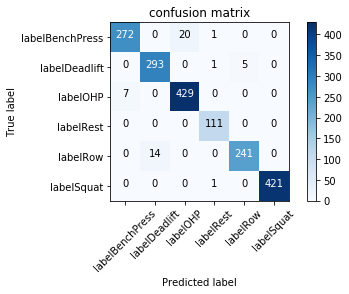

In [18]:
# Performance on the test set
test_cm = eval.confusion_matrix(test_y, class_test_y, class_train_prob_y.columns)
DataViz.plot_confusion_matrix(test_cm, class_train_prob_y.columns, normalize=False)

In [19]:
cm = confusion_matrix(test_y, class_test_y, class_train_prob_y.columns)
cr = classification_report(test_y, class_test_y, class_train_prob_y.columns)
accuracy = accuracy_score(test_y, class_test_y)

In [20]:
accuracy

0.97301762114537449